# Modelagem

## Tratamento (condensado)

Aqui é feito o tratamento completo, que foi melhor explicado em "treatment.ipynb"

Mudanças: 
1. Exclui mais colunas (ver ``# Exclusoes mais novas``)
2. Aglutina mais a coluna ``TP_ST_CONCLUSAO`` (ver ``# TP_CONCLUSAO``)
3. Aglutina coluna ``ESC_PAI`` e ``ESC_MAE``
4. Aglutina a coluna ``RENDA``
5. Aglutina a coluna ``REGIAO``

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Configurações
DATA_PATH = Path().resolve() / 'data'
ARQUIVO_AMOSTRA_PATH = DATA_PATH / 'raw' / 'microdados_enem_2023_sample.csv'

# Definição dos tipos
colunas_float = [
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
    'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
    'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'
]

colunas_string = [
    'NU_INSCRICAO', 'CO_MUNICIPIO_ESC', 'CO_MUNICIPIO_PROVA'
]

# Captura os nomes das colunas
colunas = pd.read_csv(ARQUIVO_AMOSTRA_PATH, nrows=0, encoding='latin1').columns.tolist()

# Preparar o dicionário de tipos
dtypes = {}
for col in colunas:
    if col in colunas_float:
        dtypes[col] = 'float32'
    elif col in colunas_string:
        dtypes[col] = 'string'
    else:
        dtypes[col] = 'category'

# Leitura com tipos otimizados
df = pd.read_csv(ARQUIVO_AMOSTRA_PATH, dtype=dtypes, encoding='latin1')

# REGIAO
# Define regioes...
df['REGIAO'] = df['CO_MUNICIPIO_PROVA'].apply(lambda x: x[0])
df['REGIAO'] = df['REGIAO'].astype('category')

#... e aglutina
condicoes = [
    (df['REGIAO'].isin(['1', '5'])),                 # N e C-O
    (df['REGIAO'].isin(['3', '4'])),                 # S e SE
    (df['REGIAO'].isin(['2'])),                     # NE
]

# Valores que serão atribuídos com base nas condições
valores = [1, 2, 3]

df['REGIAO'] =  np.select(condicoes, valores)
df['REGIAO'] = df['REGIAO'].astype('category')

df['REGIAO'] = df['REGIAO'].cat.rename_categories({
    '1.0': '1',
    '2.0': '2',
    '3.0': '3'
})

# Exclusoes
del df['NU_INSCRICAO']
del df['TP_FAIXA_ETARIA']
del df['CO_MUNICIPIO_ESC']                         
del df['TP_DEPENDENCIA_ADM_ESC']                   
del df['TP_LOCALIZACAO_ESC']                       
del df['TP_SIT_FUNC_ESC']
del df['TP_ENSINO']
del df['CO_MUNICIPIO_PROVA']

# TP_CONCLUSAO
condicoes = [
    (df['TP_ST_CONCLUSAO'] == '1'),                 # Concluido independente do
    (df['TP_ST_CONCLUSAO'].isin(['2', '3'])),       # Cursando EM
    (df['TP_ST_CONCLUSAO'] == '4')                  # EM não cursado
]

# Valores que serão atribuídos com base nas condições
valores = [1, 2, 3]

df['TP_CONCLUSAO'] =  np.select(condicoes, valores)
df['TP_CONCLUSAO'] = df['TP_CONCLUSAO'].astype('category')

df['TP_CONCLUSAO'] = df['TP_CONCLUSAO'].cat.rename_categories({
    '1.0': '1',
    '2.0': '2',
    '3.0': '3'
})

del df['TP_ANO_CONCLUIU']
del df['TP_ST_CONCLUSAO'] 

# TP_PRESENCA_DIA1 e TP_PRESENCA_DIA2
df.rename(columns={
    'TP_PRESENCA_CH': 'TP_PRESENCA_DIA1',
    'TP_PRESENCA_CN': 'TP_PRESENCA_DIA2'
}, inplace=True)

del df['TP_PRESENCA_LC']
del df['TP_PRESENCA_MT']

# CO_PROVA_DIA1
condicoes = [
    df['CO_PROVA_CH'].isin(['1191.0', '1192.0', '1193.0', '1194.0']),               # Prova Comum
    df['CO_PROVA_CH'].isin(['1195.0', '1196.0', '1197.0', '1198.0', '1199.0']),     # Prova Adaptada
    df['CO_PROVA_CH'].isin(['1271.0', '1272.0', '1273.0', '1274.0']),               # Prova Reaplicação
    df['CO_PROVA_CH'].isna()                                                        # Ausente
]

# Valores que serão atribuídos com base nas condições
valores = [1, 2, 3, 4]

df['CO_PROVA_DIA1'] =  np.select(condicoes, valores)
df['CO_PROVA_DIA1'] = df['CO_PROVA_DIA1'].astype('category')
del df['CO_PROVA_CH']
del df['CO_PROVA_LC'] 

# CO_PROVA_DIA2
condicoes = [
    df['CO_PROVA_CN'].isin(['1221.0', '1222.0', '1223.0', '1224.0']),               # Prova Comum
    df['CO_PROVA_CN'].isin(['1225.0', '1226.0', '1227.0', '1228.0', '1229.0']),     # Prova Adaptada
    df['CO_PROVA_CN'].isin(['1301.0', '1302.0', '1303.0', '1304.0']),               # Prova Reaplicação
    df['CO_PROVA_CN'].isna()                                            # Ausente
]

# Valores que serão atribuídos com base nas condições
valores = [1, 2, 3, 4]

df['CO_PROVA_DIA2'] = np.select(condicoes, valores)
df['CO_PROVA_DIA2'] = df['CO_PROVA_DIA2'].astype('category')
del df['CO_PROVA_CN']
del df['CO_PROVA_MT'] 

# ESC_MAE, ESC_PAI, INTERNET
df.rename(columns={
    'Q001': 'ESC_PAI',
    'Q002': 'ESC_MAE',
    'Q025': 'INTERNET'
}, inplace=True)

# ESC_PAI
condicoes = [
    df['ESC_PAI'].isin(['A']),                         # Nunca estudou
    df['ESC_PAI'].isin(['B', 'C', 'D']),               # Não tem EM completo
    df['ESC_PAI'].isin(['E', 'F', 'G']),               # Tem EM completo
    df['ESC_PAI'].isin(['H'])                         # Não sei
]

valores = [1, 2, 3, 4]

df['ESC_PAI'] =  np.select(condicoes, valores)
df['ESC_PAI'] = df['ESC_PAI'].astype('category')

# ESC_MAE
condicoes = [
    df['ESC_MAE'].isin(['A']),                         # Nunca estudou
    df['ESC_MAE'].isin(['B', 'C', 'D']),               # Não tem EM completo
    df['ESC_MAE'].isin(['E', 'F', 'G']),               # Tem EM completo
    df['ESC_MAE'].isin(['H'])                           # Não sei
]

valores = [1, 2, 3, 4]

df['ESC_MAE'] =  np.select(condicoes, valores)
df['ESC_MAE'] = df['ESC_MAE'].astype('category')

# RENDA
condicoes = [
    df['Q006'] == 'A',                  # Sem renda                    
    df['Q006'].isin(['B', 'C']),        # Renda até 1.5 SM
    (~df['Q006'].isin(['A', 'B', 'C']))   # Renda maior que 1.5 SM
]

valores = [1, 2, 3]

df['RENDA'] = np.select(condicoes, valores)
df['RENDA'] = df['RENDA'].astype(int).astype('category')

del df['Q006']

# TP_STATUS_REDACAO
condicoes = [
    df['TP_STATUS_REDACAO'] == '1.0',
    df['TP_STATUS_REDACAO'] == '2.0',
    df['TP_STATUS_REDACAO'] == '3.0',
    df['TP_STATUS_REDACAO'] == '4.0',
    df['TP_STATUS_REDACAO'] == '6.0',
    df['TP_STATUS_REDACAO'] == '7.0',
    df['TP_STATUS_REDACAO'] == '8.0',
    df['TP_STATUS_REDACAO'] == '9.0',
    df['TP_STATUS_REDACAO'].isna(),
]

valores = [1, 2, 3, 4, 6, 7, 8, 9, 10]

df['TP_STATUS_REDACAO'] =  np.select(condicoes, valores)
df['TP_STATUS_REDACAO'] = df['TP_STATUS_REDACAO'].astype('category')

# VARIÁVEIS NUMÉRICAS
# Transformacao das variaveis numericas em categoricas, segunda as faixas estipuladas
colunas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',  'NU_NOTA_REDACAO',
           'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']

for col in colunas:
    mediana = df[col].median()
    std = df[col].std()

    condicoes = [
        df[col].isna(),
        df[col] == 0,
        df[col] <= mediana,
        df[col] > mediana
    ]

    valores = [0, 1, 2, 3]

    df[col] =  np.select(condicoes, valores)
    df[col] = df[col].astype('category')

# # Proporcao das faixas das notas
# print("\n:")

# colunas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO',
#            'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']
# contagens = {}
# percentual = {}

# for col in colunas:
    
#     contagens[f'tp_{col}'] = df[col].value_counts(dropna=False)
#     percentual[f'tp_{col}_pct'] = df[col].value_counts(normalize=True, dropna=False) * 100

#     resultado = pd.DataFrame({
#         'Frequência': contagens[f'tp_{col}'],
#         'Percentual (%)': percentual[f'tp_{col}_pct'].round(2)
#     })
    
#     print(resultado, '\n')

# Exclusoes mais novas
del df['TP_NACIONALIDADE']
del df['TP_ESTADO_CIVIL']
del df['CO_PROVA_DIA1']
del df['CO_PROVA_DIA2']
del df['TP_STATUS_REDACAO']

In [2]:
for col in df.select_dtypes(include='category').columns:
    valores = df[col].unique().tolist()
    try:
        # Tenta converter para número e ordenar
        valores_ordenados = sorted(valores, key=lambda x: float(x))
    except ValueError:
        # Se não forem numéricos, mantém a ordem original
        valores_ordenados = valores
    print(f'\n{col}: {valores_ordenados}')

df.info()


TP_SEXO: ['F', 'M']

TP_COR_RACA: ['0', '1', '2', '3', '4', '5']

TP_ESCOLA: ['1', '2', '3']

IN_TREINEIRO: ['0', '1']

TP_PRESENCA_DIA2: ['0', '1', '2']

TP_PRESENCA_DIA1: ['0', '1', '2']

NU_NOTA_CN: [0, 1, 2, 3]

NU_NOTA_CH: [0, 1, 2, 3]

NU_NOTA_LC: [0, 1, 2, 3]

NU_NOTA_MT: [0, 1, 2, 3]

TP_LINGUA: ['0', '1']

NU_NOTA_COMP1: [0, 1, 2, 3]

NU_NOTA_COMP2: [0, 1, 2, 3]

NU_NOTA_COMP3: [0, 1, 2, 3]

NU_NOTA_COMP4: [0, 1, 2, 3]

NU_NOTA_COMP5: [0, 1, 2, 3]

NU_NOTA_REDACAO: [0, 1, 2, 3]

ESC_PAI: [1, 2, 3, 4]

ESC_MAE: [1, 2, 3, 4]

INTERNET: ['B', 'A']

REGIAO: [1, 2, 3]

TP_CONCLUSAO: [1, 2, 3]

RENDA: [1, 2, 3]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786791 entries, 0 to 786790
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   TP_SEXO           786791 non-null  category
 1   TP_COR_RACA       786791 non-null  category
 2   TP_ESCOLA         786791 non-null  category
 3   IN_TREINEIRO    

## Checa significâncias

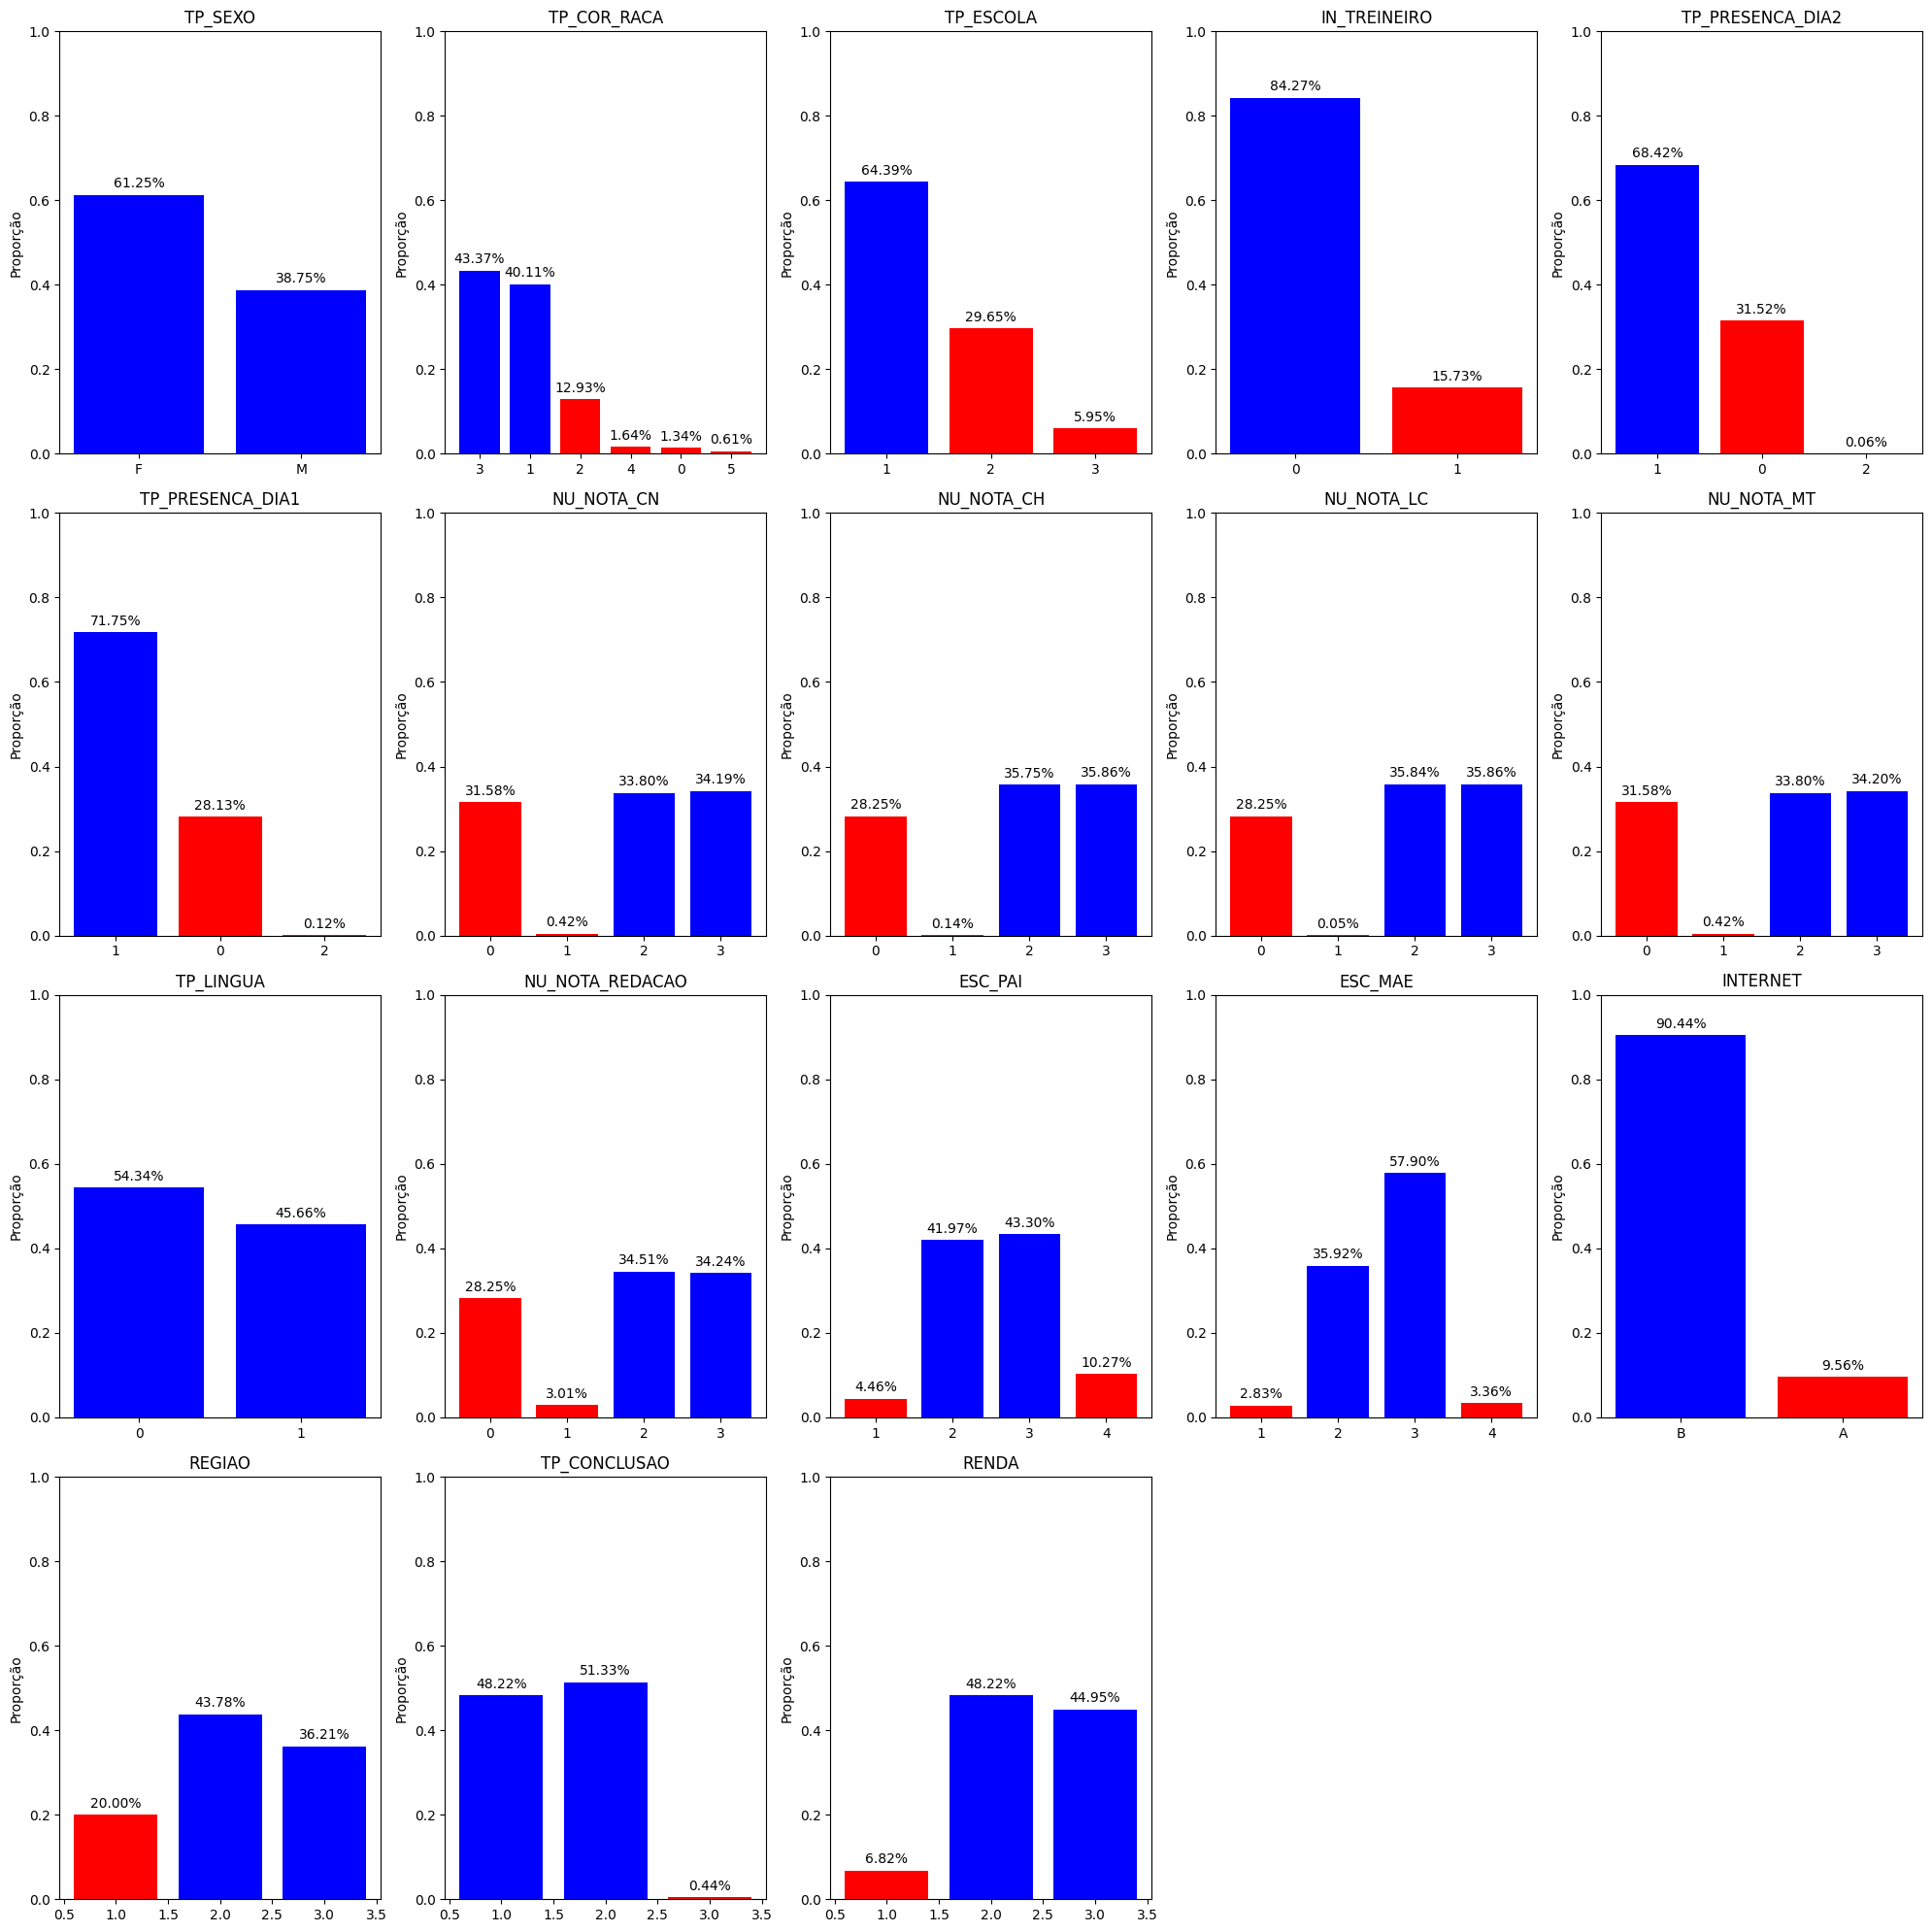

In [3]:
from utils import plot_barras_categoricas

desconsidera_cols = ['NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']
plot_barras_categoricas(df.drop(columns=desconsidera_cols), min_sup=0.33)

## Aplicando o algoritmo (suporte = 0.33)

In [4]:
# Transforma dataframe em formato transacional

desconsidera_cols = ['NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5']
df_binario = pd.get_dummies(df.drop(columns=desconsidera_cols), prefix_sep='_', dtype=bool)

print(f'Total de colunas: {len(df_binario.columns)}')
for col in df_binario.columns:
    print(col)

Total de colunas: 60
TP_SEXO_F
TP_SEXO_M
TP_COR_RACA_0
TP_COR_RACA_1
TP_COR_RACA_2
TP_COR_RACA_3
TP_COR_RACA_4
TP_COR_RACA_5
TP_ESCOLA_1
TP_ESCOLA_2
TP_ESCOLA_3
IN_TREINEIRO_0
IN_TREINEIRO_1
TP_PRESENCA_DIA2_0
TP_PRESENCA_DIA2_1
TP_PRESENCA_DIA2_2
TP_PRESENCA_DIA1_0
TP_PRESENCA_DIA1_1
TP_PRESENCA_DIA1_2
NU_NOTA_CN_0
NU_NOTA_CN_1
NU_NOTA_CN_2
NU_NOTA_CN_3
NU_NOTA_CH_0
NU_NOTA_CH_1
NU_NOTA_CH_2
NU_NOTA_CH_3
NU_NOTA_LC_0
NU_NOTA_LC_1
NU_NOTA_LC_2
NU_NOTA_LC_3
NU_NOTA_MT_0
NU_NOTA_MT_1
NU_NOTA_MT_2
NU_NOTA_MT_3
TP_LINGUA_0
TP_LINGUA_1
NU_NOTA_REDACAO_0
NU_NOTA_REDACAO_1
NU_NOTA_REDACAO_2
NU_NOTA_REDACAO_3
ESC_PAI_1
ESC_PAI_2
ESC_PAI_3
ESC_PAI_4
ESC_MAE_1
ESC_MAE_2
ESC_MAE_3
ESC_MAE_4
INTERNET_A
INTERNET_B
REGIAO_1
REGIAO_2
REGIAO_3
TP_CONCLUSAO_1
TP_CONCLUSAO_2
TP_CONCLUSAO_3
RENDA_1
RENDA_2
RENDA_3


In [ ]:
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules
import time

# 1. Gerar itemsets frequentes usando FP-Growth
print('Gerando itemsets...')

start_time = time.time()
frequent_itemsets = fpgrowth(df_binario, min_support=0.33, use_colnames=True)
end_time = time.time()
print(f"\tTempo de execução: {end_time - start_time} segundos")

# 2. Visualizar os itemsets frequentes
print(frequent_itemsets)

# 3. Gerar regras de associação a partir dos itemsets
start_time = time.time()
regras = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
end_time = time.time()
print(f"\tTempo de execução: {end_time - start_time} segundos")

# 4. Visualizar as regras
print(regras[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

In [ ]:
# Exporta pra csv
RESULTS_PATH = Path().resolve() / 'results'
frequent_itemsets.to_csv(RESULTS_PATH / 'freq_itemsets_new_33.csv')
regras.to_csv(RESULTS_PATH / 'regras_new_33_conf50.csv')

## Analisando apenas quem foi os dois dias

Para focar a análise e encontrar padrões relevantes, decidimos focar a análise apenas nos candidatos que foram nos dois dias.

Total anterior:	 786791
Total novo:	 535555


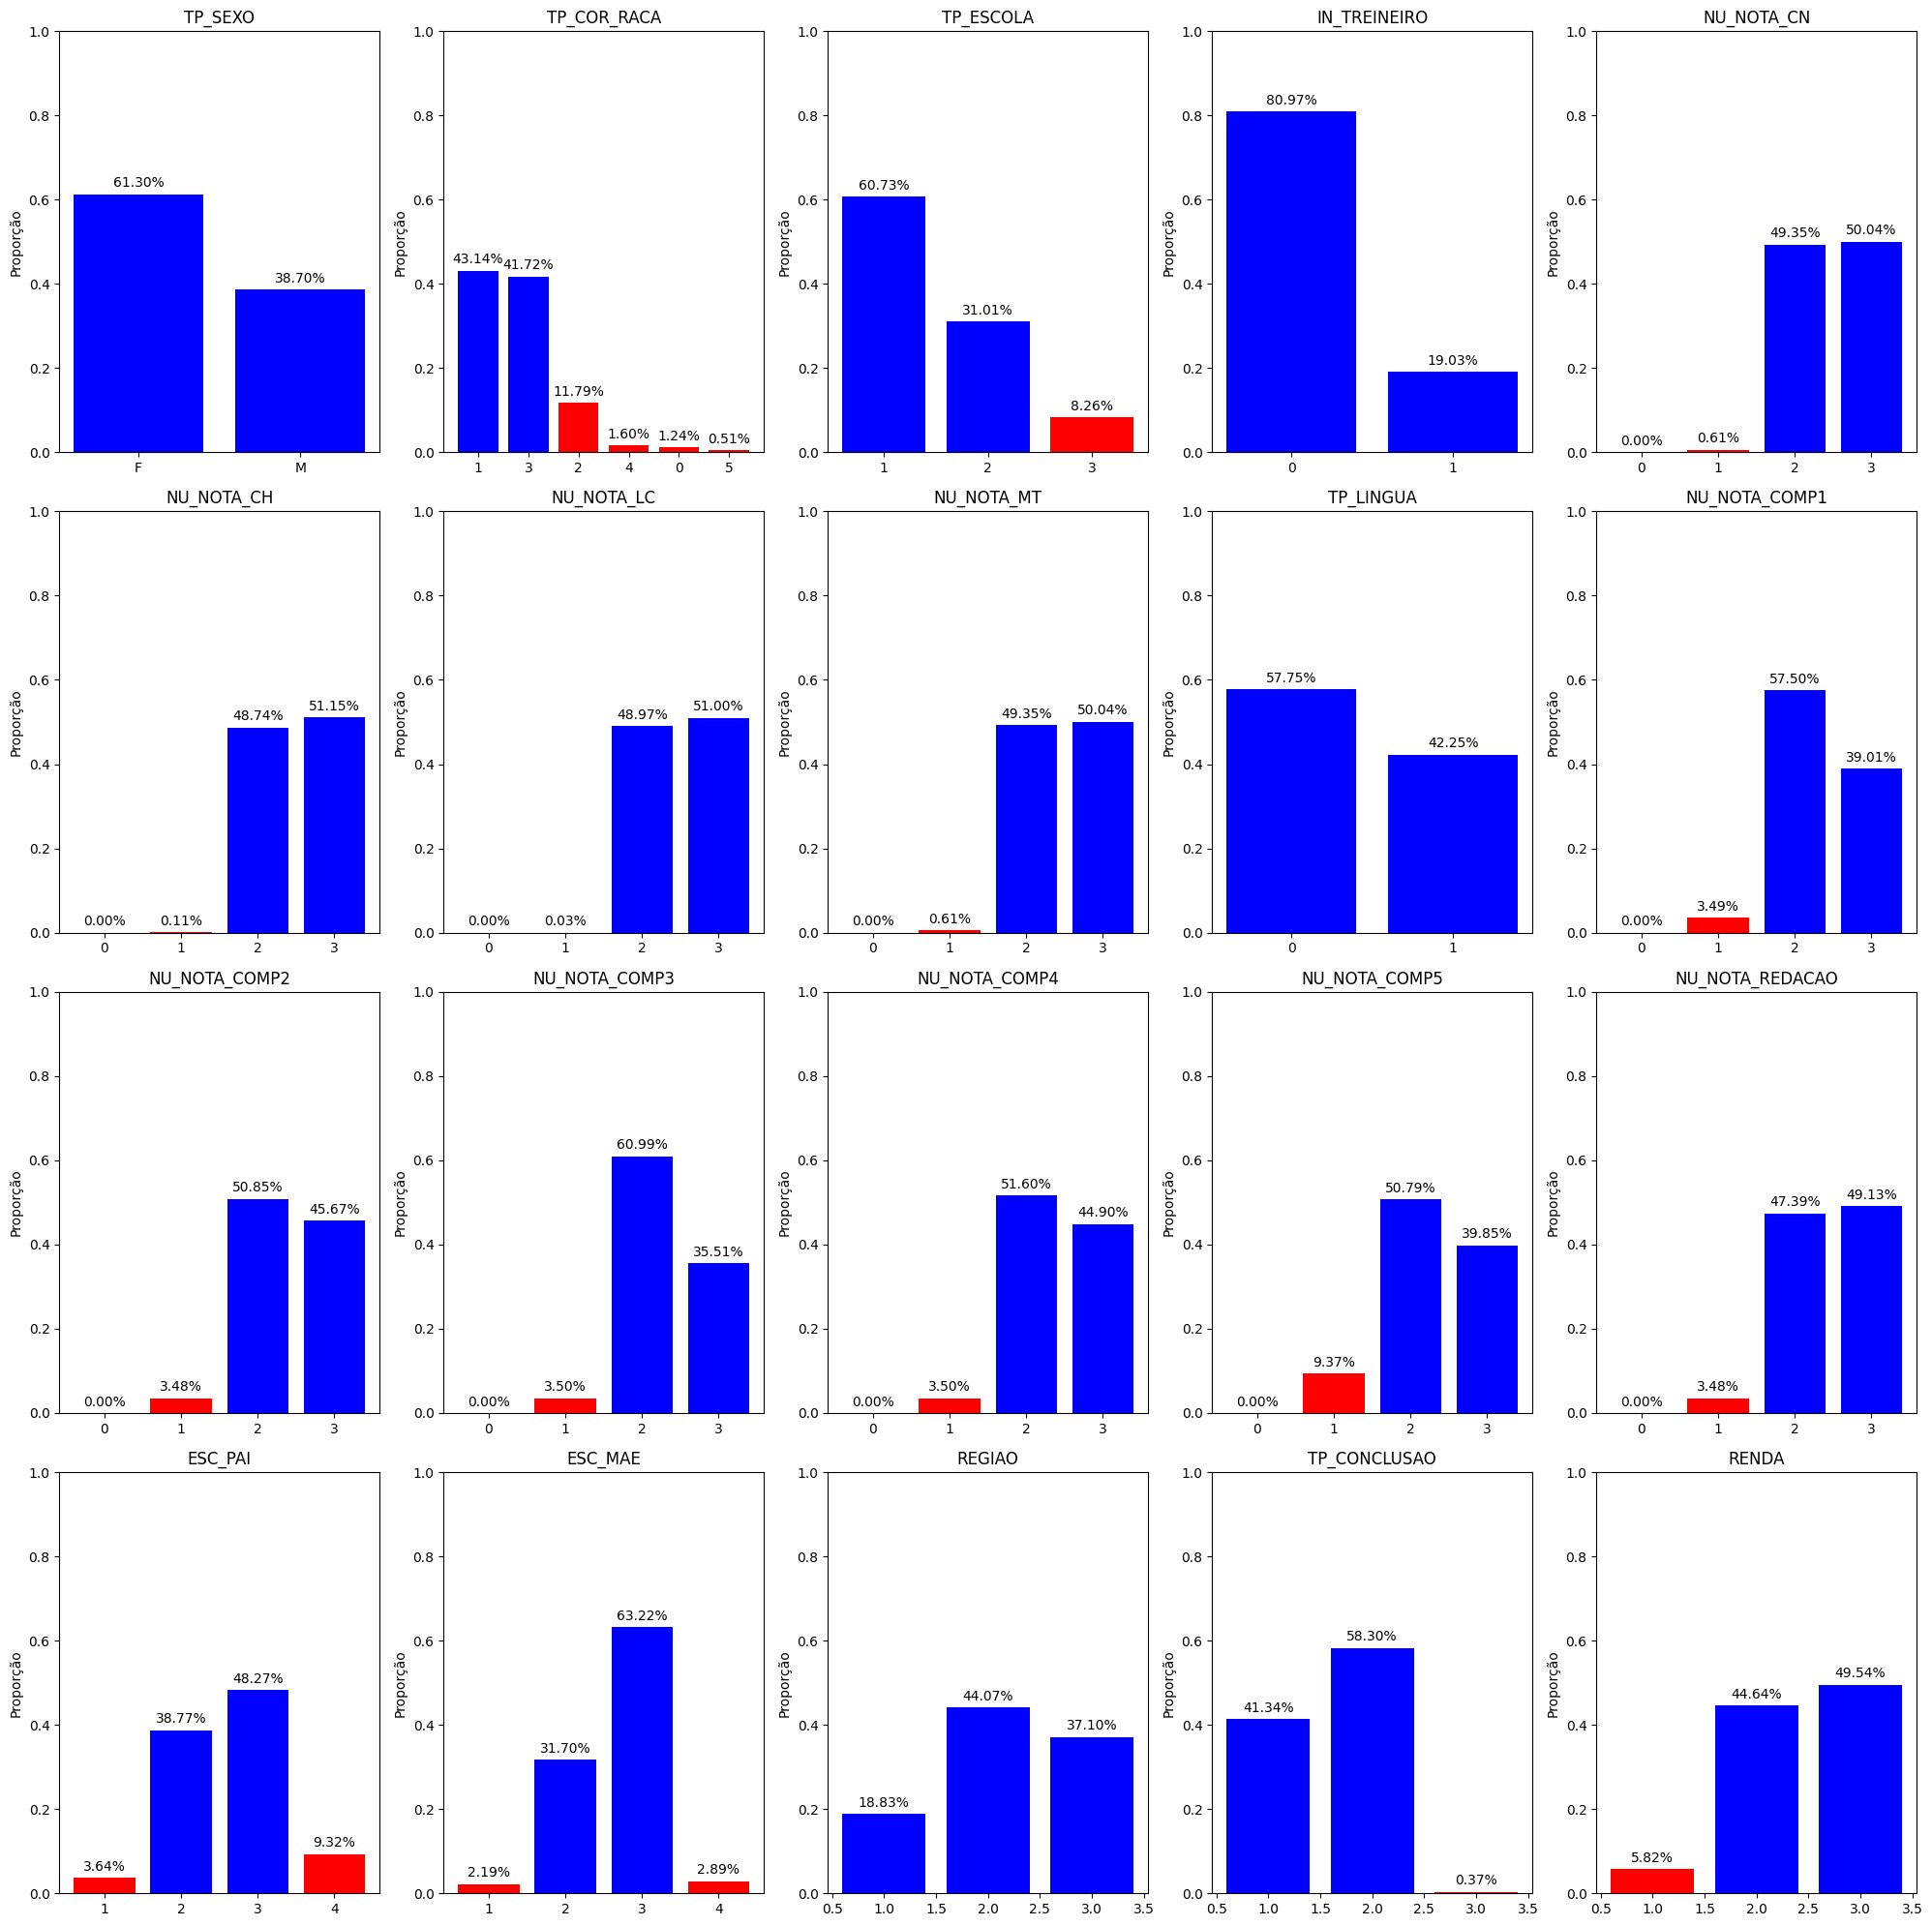

In [ ]:
from utils import plot_barras_categoricas

cols_drop = ['TP_PRESENCA_DIA2', 'TP_PRESENCA_DIA1', 'INTERNET']

df_apenas_presentes = df[(df.TP_PRESENCA_DIA1 == '1') & (df.TP_PRESENCA_DIA2 == '1')].copy()
df_apenas_presentes.drop(columns=cols_drop, inplace=True)
print(f'Total anterior:\t {len(df)}')
print(f'Total novo:\t {len(df_apenas_presentes)}')

plot_barras_categoricas(df_apenas_presentes, min_sup=0.18)

In [87]:
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules
import time

df_binario = pd.get_dummies(df_apenas_presentes, prefix_sep='_', dtype=bool)

# 1. Gerar itemsets frequentes usando FP-Growth
print('Gerando itemsets...')

start_time = time.time()
frequent_itemsets = fpgrowth(df_binario, min_support=0.18, use_colnames=True)
end_time = time.time()
print(f"\tTempo de execução: {end_time - start_time} segundos")

# Exporta pra csv
RESULTS_PATH = Path().resolve() / 'results'
frequent_itemsets.to_csv(RESULTS_PATH / 'freq_itemsets_presentes_08.csv')

Gerando itemsets...
	Tempo de execução: 6318.434493303299 segundos


In [ ]:
import pandas as pd
from pathlib import Path

# Configurações
DATA_PATH = Path().resolve()
ARQUIVO_AMOSTRA_PATH = DATA_PATH / 'data' / 'results' /'freq_itemsets_presentes_08.csv'

frequent_itemsets = pd.read_csv(ARQUIVO_AMOSTRA_PATH)
frequent_itemsets.head()

,Unnamed: 0,support,itemsets
0,0,0.809685,frozenset({'IN_TREINEIRO_0'})
1,1,0.632243,frozenset({'ESC_MAE_3'})
2,2,0.613026,frozenset({'TP_SEXO_F'})
3,3,0.609870,frozenset({'NU_NOTA_COMP3_2'})
4,4,0.582967,frozenset({'TP_CONCLUSAO_2'})


## Avaliação

In [121]:
RESULTS_PATH = Path().resolve() / 'results'
presentes = pd.read_csv(RESULTS_PATH / 'freq_itemsets_presentes_08.csv')

print(f'Padrões Frequentes: \t {len(presentes)}')
presentes.head()

Padrões Frequentes: 	 5097


,Unnamed: 0,support,itemsets
0,0,0.809685,frozenset({'IN_TREINEIRO_0'})
1,1,0.632243,frozenset({'ESC_MAE_3'})
2,2,0.613026,frozenset({'TP_SEXO_F'})
3,3,0.609870,frozenset({'NU_NOTA_COMP3_2'})
4,4,0.582967,frozenset({'TP_CONCLUSAO_2'})


In [129]:
def get_maximal_itemsets(frequent_itemsets):
    sets = frequent_itemsets.to_dict(orient='records')
    maximal_sets = []

    for i, current in enumerate(sets):
        itemset_i = current['itemsets']
        is_subset = False
        for j, other in enumerate(sets):
            if i != j and itemset_i < other['itemsets']:
                is_subset = True
                break
        if not is_subset:
            maximal_sets.append(current)

    return pd.DataFrame(maximal_sets)

In [130]:
# Calcula os conjuntos maximais
maximais = get_maximal_itemsets(frequent_itemsets)
print(f'Total de itemsets maximais: {len(maximais)}')

display(maximais)

Total de itemsets maximais: 1292


,support,itemsets
0,0.188296,(REGIAO_1)
1,0.284636,"(ESC_MAE_3, IN_TREINEIRO_0, TP_SEXO_F)"
2,0.191357,"(ESC_MAE_3, TP_SEXO_F, NU_NOTA_COMP3_2)"
3,0.254715,"(ESC_MAE_3, IN_TREINEIRO_0, TP_CONCLUSAO_2)"
4,0.240142,"(ESC_MAE_3, TP_CONCLUSAO_2, TP_SEXO_F)"
...,...,...
1287,0.180721,"(TP_SEXO_M, NU_NOTA_REDACAO_2, NU_NOTA_COMP4_2..."
1288,0.184579,"(NU_NOTA_COMP1_2, TP_SEXO_M, NU_NOTA_COMP3_2, ..."
1289,0.184510,"(NU_NOTA_COMP1_2, IN_TREINEIRO_0, TP_SEXO_M, N..."
1290,0.200794,"(ESC_MAE_3, IN_TREINEIRO_0, TP_SEXO_M)"


In [131]:
maximais_2plus = maximais[maximais.itemsets.apply(len) > 1]
print(f'Itemsets maximais que podem virar regras: {len(maximais_2plus)}')

display(maximais_2plus)

Itemsets maximais que podem virar regras: 1291


,support,itemsets
1,0.284636,"(ESC_MAE_3, IN_TREINEIRO_0, TP_SEXO_F)"
2,0.191357,"(ESC_MAE_3, TP_SEXO_F, NU_NOTA_COMP3_2)"
3,0.254715,"(ESC_MAE_3, IN_TREINEIRO_0, TP_CONCLUSAO_2)"
4,0.240142,"(ESC_MAE_3, TP_CONCLUSAO_2, TP_SEXO_F)"
5,0.219613,"(ESC_MAE_3, TP_CONCLUSAO_2, NU_NOTA_COMP3_2)"
...,...,...
1287,0.180721,"(TP_SEXO_M, NU_NOTA_REDACAO_2, NU_NOTA_COMP4_2..."
1288,0.184579,"(NU_NOTA_COMP1_2, TP_SEXO_M, NU_NOTA_COMP3_2, ..."
1289,0.184510,"(NU_NOTA_COMP1_2, IN_TREINEIRO_0, TP_SEXO_M, N..."
1290,0.200794,"(ESC_MAE_3, IN_TREINEIRO_0, TP_SEXO_M)"


In [138]:
from mlxtend.frequent_patterns import association_rules

def calc_lift_stats_de_um_itemset(itemset, all_rules):
    itemset = frozenset(itemset)

    # Seleciona regras com antecedente e consequente contidos no itemset
    regras_do_itemset = all_rules[
        all_rules['antecedents'].apply(lambda x: x.issubset(itemset) and x != itemset) &
        all_rules['consequents'].apply(lambda x: x.issubset(itemset) and x != frozenset())
    ]

    if not regras_do_itemset.empty:
        lift_min = regras_do_itemset['lift'].min()
        lift_media = regras_do_itemset['lift'].mean()
        qtd_regras = len(regras_do_itemset)
    else:
        lift_min = None
        lift_media = None
        qtd_regras = 0

    return {
        'n_itens': len(itemset),
        'qtd_regras': qtd_regras,
        'lift_min': lift_min,
        'lift_medio': lift_media
    }

In [ ]:
# Suponha que all_rules já foi gerado com:
print("Calculando regras... ")
all_rules = association_rules(frequent_itemsets, metric="support", min_threshold=0)

maximais_2plus[['n_itens', 'qtd_regras', 'lift_min', 'lift_medio']] = (
    maximais_2plus['itemsets']
    .apply(lambda x: pd.Series(calc_lift_stats_de_um_itemset(x, all_rules)))
)

/tmp/ipykernel_161522/486467269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maximais_2plus[['n_itens', 'qtd_regras', 'lift_min', 'lift_medio']] = (
/tmp/ipykernel_161522/486467269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maximais_2plus[['n_itens', 'qtd_regras', 'lift_min', 'lift_medio']] = (
/tmp/ipykernel_161522/486467269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [153]:
pd.set_option('display.max_colwidth', None)  # ou defina um número como 100
itemsets_produtivos = maximais_2plus[maximais_2plus.lift_min > 1].sort_values(by='lift_min', ascending=False)
print(f'Padrões produtivos: {len(itemsets_produtivos)}')
itemsets_produtivos.head(20)

Padrões produtivos: 680


,support,itemsets,n_itens,qtd_regras,lift_min,lift_medio
1174,0.180200,"(NU_NOTA_COMP3_3, NU_NOTA_LC_3, NU_NOTA_MT_3, NU_NOTA_COMP1_3, NU_NOTA_CH_3)",5.0,180.0,1.409198,1.938475
1199,0.180080,"(NU_NOTA_COMP3_3, NU_NOTA_LC_3, NU_NOTA_MT_3, NU_NOTA_CN_3, NU_NOTA_CH_3)",5.0,180.0,1.408833,1.775409
683,0.198934,"(RENDA_2, ESC_MAE_2)",2.0,2.0,1.405892,1.405892
1150,0.188985,"(NU_NOTA_COMP4_3, NU_NOTA_REDACAO_3, NU_NOTA_COMP5_3, NU_NOTA_COMP3_3, NU_NOTA_MT_3, NU_NOTA_COMP2_3, NU_NOTA_COMP1_3)",7.0,1932.0,1.358557,2.320919
1065,0.184989,"(NU_NOTA_COMP4_3, NU_NOTA_REDACAO_3, NU_NOTA_COMP5_3, NU_NOTA_MT_3, NU_NOTA_COMP1_3, NU_NOTA_CH_3)",6.0,602.0,1.339302,2.076500
1158,0.188623,"(NU_NOTA_COMP4_3, NU_NOTA_REDACAO_3, NU_NOTA_COMP3_3, NU_NOTA_MT_3, NU_NOTA_COMP1_3, NU_NOTA_CH_3)",6.0,602.0,1.339302,2.148840
1161,0.185901,"(NU_NOTA_COMP4_3, NU_NOTA_REDACAO_3, NU_NOTA_COMP5_3, NU_NOTA_COMP3_3, NU_NOTA_MT_3, NU_NOTA_CH_3)",6.0,602.0,1.339302,2.122571
1160,0.187135,"(NU_NOTA_COMP4_3, NU_NOTA_REDACAO_3, NU_NOTA_COMP5_3, NU_NOTA_COMP3_3, NU_NOTA_COMP2_3, NU_NOTA_COMP1_3, NU_NOTA_CH_3)",7.0,1932.0,1.333425,2.312305
1159,0.184452,"(NU_NOTA_REDACAO_3, NU_NOTA_COMP3_3, NU_NOTA_MT_3, NU_NOTA_COMP2_3, NU_NOTA_COMP1_3, NU_NOTA_CH_3)",6.0,602.0,1.333425,2.128190
1157,0.194167,"(NU_NOTA_COMP4_3, NU_NOTA_REDACAO_3, NU_NOTA_COMP3_3, NU_NOTA_MT_3, NU_NOTA_COMP2_3, NU_NOTA_CH_3)",6.0,602.0,1.333425,2.076959


In [213]:
# Considerando apenas os itemsets que nao tem a nota final da redação
itemsets_produtivos_sem_red = itemsets_produtivos[~itemsets_produtivos.itemsets.apply(
    lambda x: bool({'NU_NOTA_COMP1_2', 'NU_NOTA_COMP1_3',
                    'NU_NOTA_COMP2_2', 'NU_NOTA_COMP2_3',
                    'NU_NOTA_COMP3_2', 'NU_NOTA_COMP3_3',
                    'NU_NOTA_COMP4_2', 'NU_NOTA_COMP4_3',
                    'NU_NOTA_COMP5_2', 'NU_NOTA_COMP5_3',  
                    'TP_ESCOLA_1'} & x)
)]

print(f'Padrões produtivos sem a redação e o TP_ESCOLA_1: {len(itemsets_produtivos_sem_red)}')
display(itemsets_produtivos_sem_red.head(20))

Padrões produtivos sem a redação e o TP_ESCOLA_1: 189


,support,itemsets,n_itens,qtd_regras,lift_min,lift_medio
683,0.198934,"(RENDA_2, ESC_MAE_2)",2.0,2.0,1.405892,1.405892
456,0.198592,"(REGIAO_2, TP_COR_RACA_1, RENDA_3)",3.0,12.0,1.327213,1.455685
682,0.202646,"(ESC_MAE_2, NU_NOTA_MT_2)",2.0,2.0,1.295595,1.295595
603,0.185682,"(NU_NOTA_LC_2, NU_NOTA_CH_2, TP_LINGUA_1, NU_NOTA_MT_2)",4.0,50.0,1.279661,1.598277
488,0.196346,"(REGIAO_3, TP_COR_RACA_3)",2.0,2.0,1.268615,1.268615
394,0.194105,"(NU_NOTA_LC_2, RENDA_2, NU_NOTA_CH_2, NU_NOTA_MT_2)",4.0,50.0,1.262799,1.592410
684,0.195935,"(NU_NOTA_LC_2, ESC_MAE_2)",2.0,2.0,1.262281,1.262281
396,0.190266,"(NU_NOTA_LC_2, RENDA_2, NU_NOTA_CH_2, NU_NOTA_CN_2)",4.0,50.0,1.260238,1.582405
388,0.183968,"(NU_NOTA_LC_2, NU_NOTA_CN_2, RENDA_2, NU_NOTA_MT_2)",4.0,50.0,1.260238,1.553174
397,0.184394,"(RENDA_2, NU_NOTA_CH_2, NU_NOTA_CN_2, NU_NOTA_MT_2)",4.0,50.0,1.260238,1.556849


Selecionando alguns padrões interessantes pra analisar mais a fundo

In [214]:
def get_conf_rules_from_itemset(itemsets, itemset_id, all_rules, confidence_threshold = 0.7, lift_threshold = 1.1):
    itemset = itemsets.loc[itemset_id]
    itemset = frozenset(itemset.itemsets)

    # Seleciona regras com antecedente e consequente contidos no itemset
    regras_do_itemset = all_rules[
        all_rules['antecedents'].apply(lambda x: x.issubset(itemset) and x != itemset) &
        all_rules['consequents'].apply(lambda x: x.issubset(itemset) and x != frozenset())
    ]

    regras_do_itemset = regras_do_itemset[(regras_do_itemset['confidence'] >= confidence_threshold) & (regras_do_itemset['lift'] >= lift_threshold)]

    return regras_do_itemset

In [215]:
resultados = []

for idx, row in itemsets_produtivos_sem_red.iterrows():
    regras = get_conf_rules_from_itemset(itemsets_produtivos_sem_red, idx, all_rules, 0.7)
    if not regras.empty:
        resultados.append(regras)

conf_rules_from_prod_isets = pd.concat(resultados, ignore_index=True)

In [222]:
cols = ['antecedents',	'consequents','antecedent support',	'consequent support', 'support', 'confidence', 	'lift',	'leverage']

print(f'Regras confiantes: {len(conf_rules_from_prod_isets)}')
conf_rules_export = conf_rules_from_prod_isets[cols].sort_values(by=['leverage'], ascending=True).head(100)

Regras confiantes: 3833


In [223]:
RESULTS_PATH = Path().resolve() / 'results'

conf_rules_export.to_csv(RESULTS_PATH / 'confident_rules.csv')

Retirando regras que sejam redundantes

In [219]:
from tqdm import tqdm

def filtrar_regras_nao_redundantes(regras):
    regras = regras.copy()
    regras = regras.reset_index(drop=True)
    nao_redundantes = []

    # Use tqdm para mostrar o progresso
    for i, regra in tqdm(regras.iterrows(), total=len(regras), desc="Filtrando regras não redundantes"):
        redundante = False
        antecedente_i = regra['antecedents']
        consequente_i = regra['consequents']
        suporte_i = regra['support']

        for j, outra in regras.iterrows():
            if i == j:
                continue

            antecedente_j = outra['antecedents']
            consequente_j = outra['consequents']
            suporte_j = outra['support']

            if (
                antecedente_j < antecedente_i and  # j é subconjunto de i
                consequente_j == consequente_i and
                suporte_j == suporte_i
            ):
                redundante = True
                break

        if not redundante:
            nao_redundantes.append(regra)

    return pd.DataFrame(nao_redundantes)


In [220]:
non_redndant_conf_rules_from_prod_isets = filtrar_regras_nao_redundantes(conf_rules_from_prod_isets)

Filtrando regras não redundantes:   0%|          | 0/3833 [00:00<?, ?it/s]

Filtrando regras não redundantes:   1%|          | 28/3833 [00:15<34:48,  1.82it/s]


KeyboardInterrupt: 

In [ ]:
print(f'Numero de regras não redundantes: {len(non_redndant_conf_rules_from_prod_isets)}')

In [ ]:

# 2. Visualizar os itemsets frequentes
# print(frequent_itemsets)

# 3. Gerar regras de associação a partir dos itemsets
start_time = time.time()
regras = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
end_time = time.time()
print(f"\tTempo de execução: {end_time - start_time} segundos")

# 4. Visualizar as regras
# print(regras[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

qte_padroes_freq = len(frequent_itemsets)
qte_regras = len(regras)

print(f'Padrões Frequentes: \t {qte_padroes_freq}')
print(f'Regras de Associação: \t {qte_regras}')

# Exporta pra csv
RESULTS_PATH = Path().resolve() / 'results'
frequent_itemsets.to_csv(RESULTS_PATH / 'freq_itemsets_presentes_33.csv')
regras.to_csv(RESULTS_PATH / 'regras_presentes_33_conf50.csv')